### Evaluation of Image Classification Models

The ability to accurately understand image content holds immense value across diverse applications. Despite the availability of numerous open-source image classification architectures, their practical performance—particularly concerning memory footprint, CPU utilization, inference latency, and classification accuracy—varies significantly. This project addresses this question by evaluating these key metrics for a selection of prominent Convolutional Neural Networks (CNNs) utilizing transfer learning with a custom dataset. The analysis will provide insights into the trade-offs between different model architectures, enabling informed decision-making for deploying  image classification solutions.


 This  machine learning pipeline is designed to  compare the performance of different Convolutional Neural Network (CNN) architectures, including a custom base model and pre-trained models such as ResNet50, MobileNetV2, DenseNet121 and EfficientNetB0, on image classification tasks. It encompasses data preparation, hyperparameter optimization, model training, and a evaluation across various metrics.

 ### Data Sources

#### CIFAR-10: Training and Initial Testing Data
The CIFAR-10 dataset is a widely recognized benchmark in computer vision for image classification. It consists of 60,000 32x32 pixel color images categorized into 10 distinct classes. Each class contains 6,000 images, equally split into 50,000 images for the training set and 10,000 images for the test set.

For this project, CIFAR-10 serves as the primary dataset for training the base model and the transfer-learned architectures (ResNet50V2, DenseNet121, MobileNetV2, EfficientNetB0) and for their in-training validation.

#### CINIC-10: Independent Performance Evaluation Data

[CINIC-10](https://https://www.kaggle.com/datasets/mengcius/cinic10) an extensive dataset designed as a "bridge" between CIFAR-10 and the much larger ImageNet dataset. It comprises a total of 270,000 images, which is 4.5 times larger than CIFAR-10. These images are also 32x32 pixels color images and belong to the same 10 classes as CIFAR-10. The dataset is constructed by combining all images from CIFAR-10 with a selection of downsampled images from the ImageNet database.

CINIC-10 is equally split into three subsets: training, validation, and test, each containing 90,000 images. Within each subset, there are 9,000 images per class.

For this project, **500 images of CINIC-10 test set of every class**  will be used to evaluate the final performance of the models trained on CIFAR-10. This allows us to assess how well the models generalize to a broader and potentially more diverse set of unseen images, which is critical for real-world application where data distribution might subtly shift. This setup helps to expose potential overfitting to the CIFAR-10 training data and provides a more robust measure of the models' true generalization capabilities.


In [ ]:
 #reload python modules when they are changed
 %load_ext autoreload
 %autoreload 2

In [ ]:
#install keras-tuner if it is not installed.
from importlib.util import find_spec
if find_spec("keras-tuner"):
  print("Package 'package_name' is installed.")
else:
  print("Package 'keras-tuner' is NOT installed. Installing it.")
  !pip install keras-tuner

  print("Package 'keras-tuner' has been installed.")

Package 'keras-tuner' is NOT installed. Installing it.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 11.8 MB/s eta 0:00:00
Package 'keras-tuner' has been installed.


In [ ]:
# Imports and Global Configurations
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50, MobileNetV2, EfficientNetB0, DenseNet121
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
# Removed sklearn.metrics as it's now in utils.py if needed by those functions
from sklearn.metrics import confusion_matrix, classification_report
import keras_tuner as kt

# Import functions from your utility file
import capstone_utils

# Define global variables and constants for the pipeline.
# To write to Google drive, set the SAVE_FOLDER_PREFIX to '/content/drive/MyDrive/'
# I used Google Drive for storing my models.
SAVE_FOLDER_PREFIX = ''
# save the model to disk
SAVE_MODEL_TO_DISK = True

# source folder for the CINIC10
CINIC10_DATA_DIR = 'data/custom_test_images_from_cinic10/test'
#target image size for transfer learning.
TARGET_SIZE = (224, 224)

NUM_CLASSES = 10
BATCH_SIZE = 64
FINAL_EPOCHS = 10
MAX_TRIALS = 3
EXECUTIONS_PER_TRIAL = 2

CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Data Setup for CINIC-10

To ensure that the project runs correctly, the file  **`custom_cinic10_data.zip`**  needs to be accessible.

#### **For Google Colab Users**:
If you are running this notebook on Google Colab,  upload `custom_cinic10_data.zip`  to your Colab environment in the `/content` folder before executing the following cell.

Important Note: If you run this cell multiple times then the '<i>-o</o>' option will overwrite the existing files. This shouldn't cause any issues.

After the unzip operation, you should see the following folders:

`data/custom_test_images_from_cinic10/test/airplane`
<br/>`data/custom_test_images_from_cinic10/test/automobile`
<br/>`data/custom_test_images_from_cinic10/test/bird`
<br/>`data/custom_test_images_from_cinic10/test/cat`
<br/>`data/custom_test_images_from_cinic10/test/deer`
<br/>`data/custom_test_images_from_cinic10/test/dog`
<br/>`data/custom_test_images_from_cinic10/test/frog`
<br/>`data/custom_test_images_from_cinic10/test/horse`
<br/>`data/custom_test_images_from_cinic10/test/ship`
<br/>`data/custom_test_images_from_cinic10/test/truck`
<br/>

The `/content` folder is cleaned up every time a new runtime is started or the CPU type is changed. Ensure that the file is unzippped before evaluating models.

<i>**Disclaimer**: This notebook was executed and validated using Google Colab Pro to leverage its enhanced computational resources. While the code is designed to be compatible with local environments, its functionality on a local machine has not been explicitly verified due to the extensive computational time required for training and evaluating these models.</i>

In [ ]:
# Unzip custom_cinic10_data.zip
!unzip -q -o custom_cinic10_data.zip

### **If you use google drive for storing models then make sure that the drive is mounted properly.  I used Google Drive for storing my models**   

Even though I used Google Drive for storing my models,  I have changed the save folder prefix (SAVE_FOLDER_PREFIX) to the default folder as the grader may not be comfortable giving access to their google drive.

In [ ]:

 # Conditionally mount Google Drive if in a Colab environment and the prefix is set.
if SAVE_FOLDER_PREFIX == '/content/drive/MyDrive/' and 'google.colab' in str(get_ipython()):
  print("Mounting Google Drive...")
  capstone_utils.mount_google_drive()
 else:
  print("Google Drive is not mounted.")


Mounting Google Drive...
Mounting Google Drive...
Mounted at /content/drive


### Data Loading and Preprocessing (load_and_preprocess_dataset, load_cinic10_test_dataset, preprocess_func_base and others)

This initial stage handles the acquisition and preparation of image data for model consumption.

**CIFAR-10 Loading and Augmentation**: The load_and_preprocess_dataset function loads the CIFAR-10 dataset. It then performs crucial preprocessing steps:

**One-Hot Encoding**: Converts integer labels (e.g., 0, 1, 2) into a binary vector format (e.g., [1, 0, 0], [0, 1, 0]), which is suitable for categorical cross-entropy loss.

**Image Resizing**: All images are resized to a TARGET_SIZE (e.g., 224x224 pixels), ensuring uniform input dimensions for the models. ResNet, MobileNet, DenseNet and EfficientNetB0 operate on imagenet data of the dimension 224x224.

**Model-Specific Preprocessing**: A preprocess_func (like preprocess_func_base or those for pre-trained models, e.g., tf.keras.applications.resnet50.preprocess_input) is applied. This typically involves pixel scaling (e.g., normalizing to [0, 1] or [-1, 1]) and other specific operations required by the pre-trained models.

**Data Augmentation**: For the training dataset, a keras.Sequential model applies random transformations such as horizontal flips, rotations, and zooms. This artificially expands the dataset, helping the model generalize better and reducing overfitting.

**Dataset Pipelining**: tf.data.Dataset is used to create efficient data pipelines, including shuffling (for randomness during training), batching (grouping samples for parallel processing), and prefetching (overlapping data loading and model execution). When tf.data.Dataset is used, this batch size overrides the batch size used in the fir function.

**CINIC-10 Test Data Loading**: The load_cinic10_test_dataset function specifically loads the CINIC-10 test set. This dataset is kept separate from the training data and is used for an independent, final evaluation of the trained models to assess their generalization capabilities on a  subset of larger distribution of images within the same classes. It undergoes resizing and model-specific preprocessing but not augmentation, as it's for evaluation.

In [ ]:
def load_and_preprocess_dataset(preprocess_func):
    """
    Loads CIFAR-10 and creates a preprocessed dataset using a given function.

    Args:
        preprocess_func (function): The model-specific preprocessing function.

    Returns:
        tuple: Preprocessed training and test datasets, and raw test images/labels.
    """
    print("Loading CIFAR-10 dataset...")
    (train_images, train_labels), (test_images, test_labels) = keras.datasets.cifar10.load_data()

    train_labels_one_hot = keras.utils.to_categorical(train_labels, NUM_CLASSES)
    test_labels_one_hot = keras.utils.to_categorical(test_labels, NUM_CLASSES)

    def preprocess(image, label):
        """Resizes and normalizes a single image using the specified function."""
        image = tf.image.resize(image, TARGET_SIZE)
        image = preprocess_func(image)
        return image, label

    # Create and preprocess the training dataset with augmentation.
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels_one_hot))
    data_augmentation = keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ])
    train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    # Create and preprocess the test dataset.
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels_one_hot))
    test_dataset = test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

    return train_dataset, test_dataset, test_images, test_labels


def load_cinic10_test_dataset(preprocess_func):
    """
    Loads and pre-processes the CINIC-10 test dataset for evaluation.

    Args:
        preprocess_func (function): The model-specific pre-processing function.

    Returns:
        tf.data.Dataset: The pre-processed CINIC-10 test dataset.
    """
    print("Loading CINIC-10 test dataset for evaluation...")
    cinic10_test_dataset = tf.keras.utils.image_dataset_from_directory(
        CINIC10_DATA_DIR,
        labels='inferred',
        label_mode='categorical',
        image_size=TARGET_SIZE,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    def preprocess(image, label):
        image = preprocess_func(image)
        return image, label

    cinic10_test_dataset = cinic10_test_dataset.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    cinic10_test_dataset = cinic10_test_dataset.prefetch(tf.data.AUTOTUNE)

    return cinic10_test_dataset


def preprocess_func_base(image):
    """
    Preprocessing function for the custom base model.
    Resizes and scales pixel values to [0, 1].
    """
    image = tf.cast(image, tf.float32) / 255.0
    return image

### Model Pipeline Execution (run_model_pipeline Function)
The run_model_pipeline function orchestrates the entire process for each specified model (BaseModel, ResNet50V2, DenseNet121, MobileNetV2, EfficientNetB0).


**Hyperparameter Tuning (Keras Tuner)**:

Use keras_tuner.RandomSearch to find the best combination of hyperparameters (e.g., learning rate, number of units in dense layers) based on val_accuracy on the CIFAR-10 validation set. CIFAR-10 test set is used as a validation set. The following two hyper parameters are considered:

1. learning rate
2. number of units in dense layers


**Search Process**: The tuner searches across defined ranges for hyperparameters, training multiple models for a few epochs to identify promising combinations.

**Model Selection and Compilation**: After the search, the best performing model and its hyperparameters are retrieved from the tuner. The model is then compiled with the optimal learning rate, a categorical cross-entropy loss function, and accuracy metrics. Optionally, best performing models are written to incurring disk for later analysis without training time.

**Final Model Training**: The selected best model is trained for FINAL_EPOCHS on the preprocessed and augmented CIFAR-10 training dataset, with validation on the CIFAR-10 test set. Training time is recorded.

**Visualization**: A bar plot visualizes the validation accuracy of different hyperparameter trials, providing an immediate overview of the tuning results. After training, plots are generated to visualize the training and validation loss and accuracy curves over epochs. This helps in understanding learning progress and identifying overfitting or underfitting.

**Result Tracking**: A dictionary stores all relevant results, including model objects, datasets, performance metrics (accuracy, loss, time), and data for later plotting (training history, true/predicted labels).


### Model Evaluation and Analysis
After training, the models undergo a comprehensive evaluation phase.

**CIFAR-10 Test Set Evaluation**: The trained model's performance is first evaluated on the CIFAR-10 test dataset to get final loss and accuracy metrics.

**CINIC-10 Test Set Evaluation**: The model is then evaluated on the CINIC-10 test dataset. This separate evaluation provides an assessment of the model's generalization ability to unseen data that might have different underlying characteristics than the CIFAR-10 training set.

**Key Metrics for Evaluation**

1. Total Parameters
2. Training Time (s)
3. Tuner Search Time (s)
4. Train Accuracy
5. Train Loss
6. Validation Accuracy
7. Validation Loss
8. CINIC-10 Test Accuracy
9. CINIC-10 Test Loss
10. Inference Time Per Sample (s)
11. In-Memory Model Size (MB)
12. File-Based Model Size (MB)
13. Confusion Matrix and Classification Report


In [ ]:
def run_model_pipeline(model_name, build_hypermodel_func, preprocess_func, tuner_dir, save_path, folder_prefix):
    """
    Runs the full pipeline, returning a dictionary of all results,
    including data needed to recreate plots later.
    """
    print(f"\n====================== Starting Pipeline for {model_name} ======================")

    results = {
        'model_name': model_name,
        'model': None,
        'datasets': {},
        'metrics': {},
        # New key to store all data needed for plotting
        'plotting_data': {
            'class_names': CLASS_NAMES,
            'history': None,
            'y_true_classes': None,
            'y_pred_classes': None
        }
    }

    tuner_dir_with_prefix = os.path.join(folder_prefix, tuner_dir)
    save_path_with_prefix = os.path.join(folder_prefix, save_path)

    if SAVE_MODEL_TO_DISK:
        save_dir = os.path.dirname(save_path_with_prefix)
        os.makedirs(save_dir, exist_ok=True)

    train_ds, test_ds, _, _ = load_and_preprocess_dataset(preprocess_func)
    results['datasets']['cifar10_train'] = train_ds
    results['datasets']['cifar10_test'] = test_ds

    start_tuner_search_time = time.time()
    tuner = kt.RandomSearch(
        hypermodel=build_hypermodel_func,
        objective='val_accuracy',
        max_trials=MAX_TRIALS,
        executions_per_trial=EXECUTIONS_PER_TRIAL,
        directory=tuner_dir_with_prefix,
        project_name=f'{model_name}_cifar10_hp_tuning'
    )
    print(f"\nStarting hyperparameter search for {model_name}...")
    tuner.search(train_ds, epochs=1, validation_data=test_ds)
    results['metrics']['tuner_search_time'] = time.time() - start_tuner_search_time
    print(f"Hyperparameter search time for {model_name}: {results['metrics']['tuner_search_time']:.2f} seconds")

    # === New Visualization Code for Hyperparameter Tuning ===
    print(f"\nPlotting hyperparameter tuning results for {model_name}...")
    all_trials = tuner.oracle.get_best_trials(num_trials=MAX_TRIALS)
    trial_labels = [f"Trial {i+1}\nLR: {t.hyperparameters.values['learning_rate']}\nUnits: {t.hyperparameters.values['units']}" for i, t in enumerate(all_trials)]
    trial_scores = [t.score for t in all_trials]
    plt.figure(figsize=(10, 6))
    bars = plt.bar(trial_labels, trial_scores, color='skyblue')
    plt.xlabel("Hyperparameter Combinations")
    plt.ylabel("Validation Accuracy")
    plt.title(f"Keras Tuner Results for {model_name}")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.4f}', ha='center', va='bottom')
    plt.show()
    # === End of New Visualization Code ===

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    best_model = tuner.get_best_models(num_models=1)[0]
    total_params = best_model.count_params()
    print(f"Total Parameters for {model_name}: {total_params}")
    results['metrics']['total_parameters'] = total_params
    results['model'] = best_model

    print(f"\nBest hyperparameters for {model_name}:")
    print(f"  - Learning Rate: {best_hps.get('learning_rate')}")
    print(f"  - Dense Units: {best_hps.get('units')}")

    print(f"\nStarting final training of the best {model_name} model...")
    best_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=best_hps.get('learning_rate')),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")]
    )

    start_time = time.time()
    history = best_model.fit(
        train_ds,
        epochs=FINAL_EPOCHS,
        validation_data=test_ds
    )
    # Save the history object to the results dictionary
    results['plotting_data']['history'] = history.history

    results['metrics']['training_time'] = time.time() - start_time
    print(f"Training Time for {model_name}: {results['metrics']['training_time']:.2f} seconds")

    results['metrics']['cifar10_train_accuracy'] = history.history['accuracy'][-1]
    results['metrics']['cifar10_train_loss'] = history.history['loss'][-1]
    results['metrics']['cifar10_val_accuracy'] = history.history['val_accuracy'][-1]
    results['metrics']['cifar10_val_loss'] = history.history['val_loss'][-1]

    # Plot loss and accuracy curves
    print(f"\nPlotting loss and accuracy curves for {model_name}...")
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Loss Curves for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Accuracy Curves for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Final evaluation on the CIFAR-10 test set.
    cifar_test_loss, cifar_test_accuracy = best_model.evaluate(test_ds)
    results['metrics']['cifar10_test_loss'] = cifar_test_loss
    results['metrics']['cifar10_test_accuracy'] = cifar_test_accuracy
    print(f"\nFinal Test Loss ({model_name} on CIFAR-10): {cifar_test_loss:.4f}")
    print(f"Final Test Accuracy ({model_name} on CIFAR-10): {cifar_test_accuracy:.4f}")

    # === Evaluation on CINIC-10 dataset ===
    print(f"\n--- Evaluating {model_name} on CINIC-10 Test Dataset ---")
    cinic10_test_ds = load_cinic10_test_dataset(preprocess_func)
    results['datasets']['cinic10_test'] = cinic10_test_ds

    cinic10_test_loss, cinic10_test_accuracy = best_model.evaluate(cinic10_test_ds)

    results['metrics']['cinic10_test_loss'] = cinic10_test_loss
    results['metrics']['cinic10_test_accuracy'] = cinic10_test_accuracy
    print(f"\nFinal Test Loss ({model_name} on CINIC-10): {cinic10_test_loss:.4f}")
    print(f"Final Test Accuracy ({model_name} on CINIC-10): {cinic10_test_accuracy:.4f}")
    # ============================================

    start_time_inference = time.time()
    y_pred_probs = best_model.predict(test_ds)
    end_time_inference = time.time()
    inference_time_per_sample = (end_time_inference - start_time_inference) / len(test_ds)
    results['metrics']['inference_time_per_sample'] = inference_time_per_sample
    print(f"Inference Time per Sample ({model_name}): {inference_time_per_sample:.4f} seconds")

    model_size_mb_in_memory = capstone_utils.get_in_memory_model_size(best_model)
    results['metrics']['in_memory_model_size_mb'] = model_size_mb_in_memory
    print(f"In-memory Model Size ({model_name}): {model_size_mb_in_memory:.2f} MB")

    print(f"\nGenerating confusion matrix for {model_name} on CIFAR-10...")
    y_true = np.concatenate([y for x, y in test_ds], axis=0)
    y_pred_probs = best_model.predict(test_ds)
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true_classes = np.argmax(y_true, axis=1)

    # Save the true and predicted classes to the results dictionary
    results['plotting_data']['y_true_classes'] = y_true_classes
    results['plotting_data']['y_pred_classes'] = y_pred_classes

    cm = confusion_matrix(y_true_classes, y_pred_classes, labels=range(NUM_CLASSES))

    print(f"\nClassification Report for {model_name} on CIFAR-10:")
    report = classification_report(y_true_classes, y_pred_classes, target_names=CLASS_NAMES, output_dict=True)
    print(classification_report(y_true_classes, y_pred_classes, target_names=CLASS_NAMES))
    results['metrics']['classification_report'] = report

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name} on CIFAR-10 Test Data')
    plt.show()

    if SAVE_MODEL_TO_DISK:
        best_model.save(save_path_with_prefix)
        print(f"Model saved successfully to {save_path_with_prefix}.")
        model_size_bytes_on_disk = capstone_utils.get_file_or_dir_size(save_path_with_prefix)
        model_size_mb_on_disk = model_size_bytes_on_disk / (1024 * 1024)
        print(f"File-based Model Size ({model_name}): {model_size_mb_on_disk:.2f} MB")
        results['metrics']['file_based_model_size_mb'] = model_size_mb_on_disk
    else:
        print("Model saving is disabled by the SAVE_MODEL_TO_DISK flag.")

    print(f"\n====================== Pipeline for {model_name} Finished ======================")
    return results

### Hypermodel Functions

 Separate build_hypermodel_ functions (e.g., build_hypermodel_base, build_hypermodel_resnet) define the architecture for each model type. These functions incorporate configurable hyperparameters for the tuner to explore. For transfer learning models (ResNet50, MobileNetV2, EfficientNetB0, DenseNet121), the pre-trained convolutional base is loaded with imagenet weights and initially frozen (base_model.trainable = False), and only the newly added classification layers are tuned.


In [ ]:
def build_hypermodel_base(hp):
    """Builds a simple custom CNN model with a configurable dense layer and learning rate."""
    model = keras.Sequential([
        layers.Input(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)),
        layers.Conv2D(16, (3, 3), activation='relu'),
        layers.MaxPooling2D(pool_size=(3, 3)),
        layers.Flatten(),
        layers.Dense(units=hp.Int('units', min_value=32, max_value=64, step=16), activation='relu'),
        layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")]
    )
    return model

def build_hypermodel_resnet(hp):
    """Builds a ResNet50 model with a configurable top dense layer."""
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)
    )
    base_model.trainable = False  # Freeze the base model

    inputs = keras.Input(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)

    units = hp.Int('units', min_value=128, max_value=512, step=64)
    x = layers.Dense(units, activation='relu')(x)

    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs, outputs)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")]
    )
    return model

def build_hypermodel_mobilenet(hp):
    """Builds a MobileNetV2 model with a configurable top dense layer."""
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)

    units = hp.Int('units', min_value=128, max_value=512, step=64)
    x = layers.Dense(units, activation='relu')(x)

    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs, outputs)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")]
    )
    return model

def build_hypermodel_efficientnet(hp):
    """Builds an EfficientNetB0 model with a configurable top dense layer."""
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)

    units = hp.Int('units', min_value=128, max_value=512, step=64)
    x = layers.Dense(units, activation='relu')(x)

    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs, outputs)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")]
    )
    return model

def build_hypermodel_densenet(hp):
    """Builds a DenseNet121 model with a configurable top dense layer."""
    base_model = DenseNet121(
        weights='imagenet',
        include_top=False,
        input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)
    )
    base_model.trainable = False

    inputs = keras.Input(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)

    units = hp.Int('units', min_value=128, max_value=512, step=64)
    x = layers.Dense(units, activation='relu')(x)

    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    model = Model(inputs, outputs)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")]
    )
    return model

In [ ]:

    # Use a dictionary to store the results from each model run.
    all_results = {}


Trial 3 Complete [00h 00m 50s]
val_accuracy: 0.4061499983072281

Best val_accuracy So Far: 0.4061499983072281
Total elapsed time: 00h 02m 35s
Hyperparameter search time for BaseModel: 156.08 seconds

Plotting hyperparameter tuning results for BaseModel...


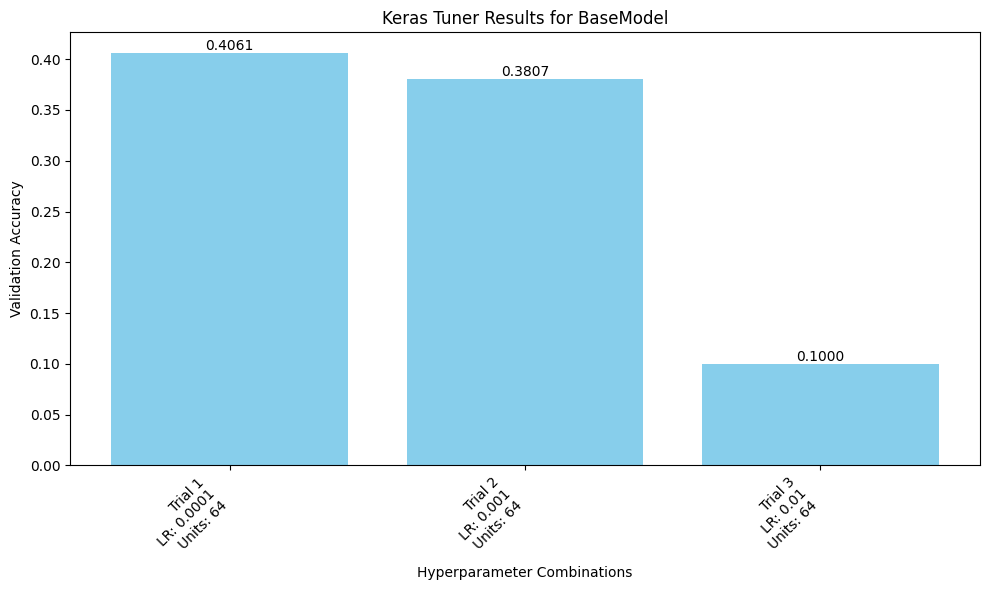

Total Parameters for BaseModel: 5608586

Best hyperparameters for BaseModel:
  - Learning Rate: 0.0001
  - Dense Units: 64

Starting final training of the best BaseModel model...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.3828 - loss: 1.7428 - val_accuracy: 0.4242 - val_loss: 1.6400
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.4099 - loss: 1.6772 - val_accuracy: 0.4413 - val_loss: 1.5850
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.4253 - loss: 1.6351 - val_accuracy: 0.4534 - val_loss: 1.5622
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.4356 - loss: 1.6077 - val_accuracy: 0.4621 - val_loss: 1.5354
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.4457 - loss: 1.5863 - val_accuracy: 0.4722 - val_loss: 1.5093
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.4520 - loss: 1.5645 - val_accuracy: 0.4723 - val_loss: 1.5072
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.4541 - loss: 1.5524 - val_accuracy: 0.4886 - val_loss: 1.4700
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 20s 25ms/step - accuracy: 0.4617 - loss: 1.5322 - val_accurac

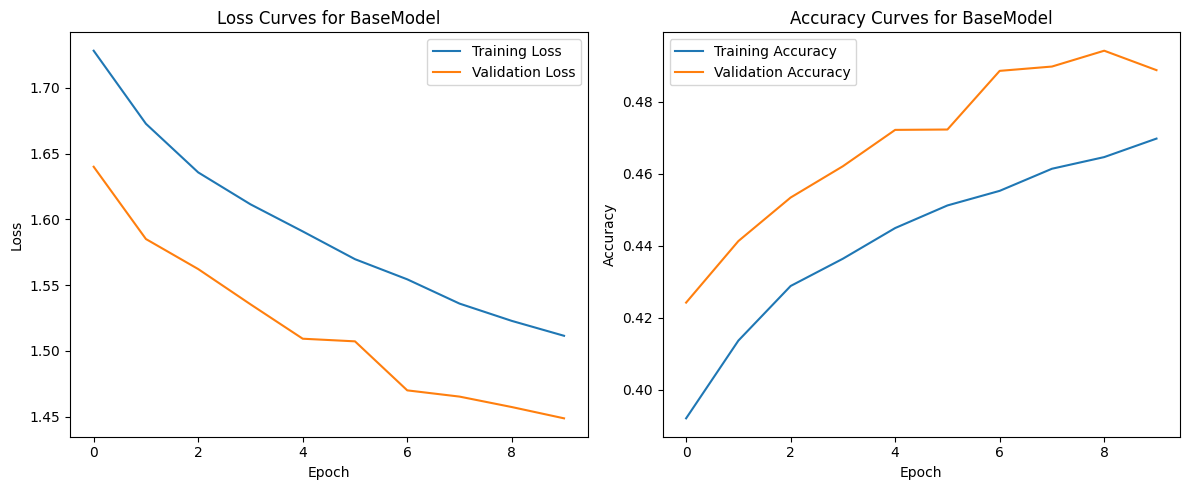

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4904 - loss: 1.4388

Final Test Loss (BaseModel on CIFAR-10): 1.4487
Final Test Accuracy (BaseModel on CIFAR-10): 0.4888

--- Evaluating BaseModel on CINIC-10 Test Dataset ---
Loading CINIC-10 test dataset for evaluation...
Found 5000 files belonging to 10 classes.
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.3615 - loss: 1.8137

Final Test Loss (BaseModel on CINIC-10): 1.8305
Final Test Accuracy (BaseModel on CINIC-10): 0.3536
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Inference Time per Sample (BaseModel): 0.0112 seconds
Calculating model size in memory...
In-memory Model Size (BaseModel): 21.40 MB

Generating confusion matrix for BaseModel on CIFAR-10...
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

Classification Report for BaseModel on CIFAR-10:
              precision    recall  f1-score   support

    airplane       0.68      0.40      0.50      1000
  automobile       0.53      0.65      0.58      1000
        bird      

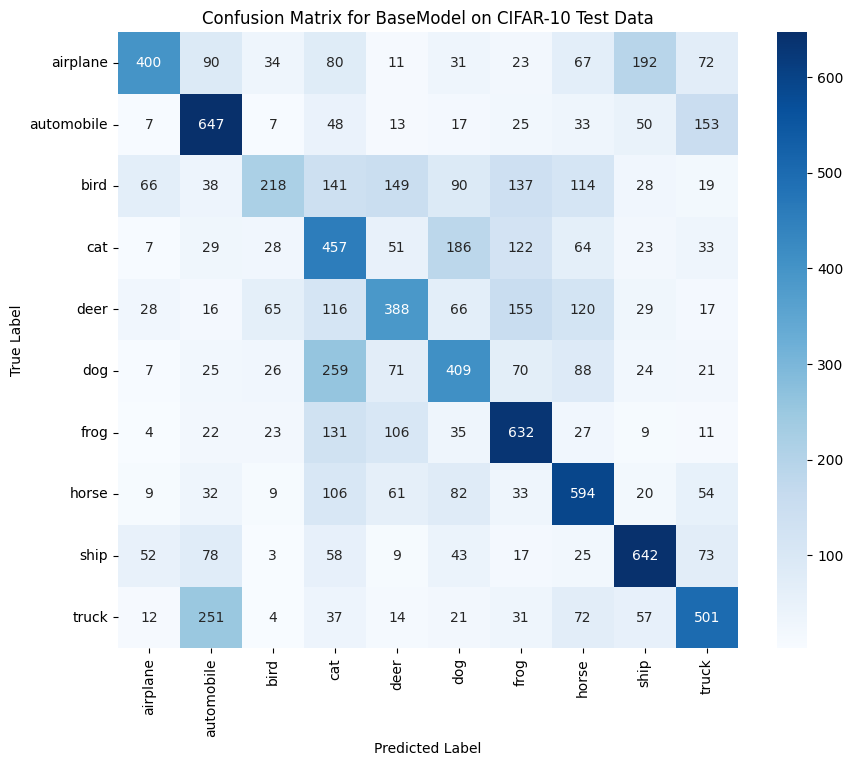

Model saved successfully to /content/drive/MyDrive/models/base_model_cifar10.keras.
File-based Model Size (BaseModel): 64.21 MB

====================== Pipeline for BaseModel Finished ======================


In [ ]:
# Run the pipeline for the custom base model
base_model_results = run_model_pipeline(
model_name="BaseModel",
build_hypermodel_func=build_hypermodel_base,
preprocess_func=preprocess_func_base,
tuner_dir="tuner_results",
save_path="models/base_model_cifar10.keras",
folder_prefix = SAVE_FOLDER_PREFIX)

all_results["BaseModel"] = base_model_results

In [ ]:
print(all_results["BaseModel"]["metrics"])

{'tuner_search_time': 156.078382730484, 'total_parameters': 5608586, 'training_time': 203.29644107818604, 'cifar10_train_accuracy': 0.46977999806404114, 'cifar10_train_loss': 1.5114715099334717, 'cifar10_val_accuracy': 0.4887999892234802, 'cifar10_val_loss': 1.448734998703003, 'cifar10_test_loss': 1.448734998703003, 'cifar10_test_accuracy': 0.4887999892234802, 'cinic10_test_loss': 1.8305257558822632, 'cinic10_test_accuracy': 0.35359999537467957, 'inference_time_per_sample': 0.011221773305516334, 'in_memory_model_size_mb': 21.395057678222656, 'classification_report': {'airplane': {'precision': 0.6756756756756757, 'recall': 0.4, 'f1-score': 0.5025125628140703, 'support': 1000.0}, 'automobile': {'precision': 0.5268729641693811, 'recall': 0.647, 'f1-score': 0.5807899461400359, 'support': 1000.0}, 'bird': {'precision': 0.5227817745803357, 'recall': 0.218, 'f1-score': 0.3076923076923077, 'support': 1000.0}, 'cat': {'precision': 0.3189113747383112, 'recall': 0.457, 'f1-score': 0.3756678997122

In [ ]:
base_model = base_model_results['model']
base_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,607,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,825,760 (64.19 MB)

 Trainable params: 5,608,586 (21.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 11,217,174 (42.79 MB)

### Performance Analysis of the Base Model
#### HyperParameter Tuning

The plot shows the validation accuracy for each hyperparameter combination tested. The best trial with a learning rate of 0.0001 and 64 dense units was selected for the final model.

#### Analysis of Training Performance


**Accuracy**: The training accuracy goes from 38.28% to 46.76%, and the validation accuracy from 42.42% to 48.88%.

**Loss**: The training loss starts high at 1.7428 and  decreases to 1.5085. This trend aligns with the rising accuracy and shows the model is becoming more confident in its predictions on the training data.The validation loss also decreases throughout training from 1.6400 to 1.4487.

Overall, the accuracy being less than 50% is an indication that the model may not be complex for this data.

#### Per-Class Performance

**Best-Performing Classes**: The model did its "best" with ship and automobile, with F1-scores of 0.62 and 0.58, respectively. This indicates it was slightly more effective at identifying these types of images.

**Worst-Performing Classes**: The model performed poorly on the cat and bird classes, which have the lowest F1-scores of 0.38 and 0.31. he low precision for cat (0.32) and high recall (0.46) suggests the model is very hesitant to predict cat but when it does, it's often wrong. It's likely confusing cats with other similar animals like dogs.  The bird class had an exceptionally low recall (0.22), meaning the model failed to find most of the bird images.

The low scores across the board, especially the low overall accuracy, suggest that this BaseModel is not suitable for the complexity of the CIFAR-10 dataset.

Heatmap observations give us insight into True Positives and False Negatives on a per class basis.

<br/>**Training Time is 203.30 seconds**


#### Custom Data Testing with CINIC10

Eventhough the validation accuracy is 48.88%, the accuracy of custom CINIC10 data is only 35.36% which could point to overfitting and poor generalization.


#### Other Metrics

- Inference Time per Sample is 0.0112 seconds
- In-memory Model Size is 21.40
- File-based Model Size is 64.21MB

Trial 3 Complete [00h 01m 38s]
val_accuracy: 0.7661000192165375

Best val_accuracy So Far: 0.7900999784469604
Total elapsed time: 00h 05m 03s
Hyperparameter search time for MobileNetV2: 305.42 seconds

Plotting hyperparameter tuning results for MobileNetV2...


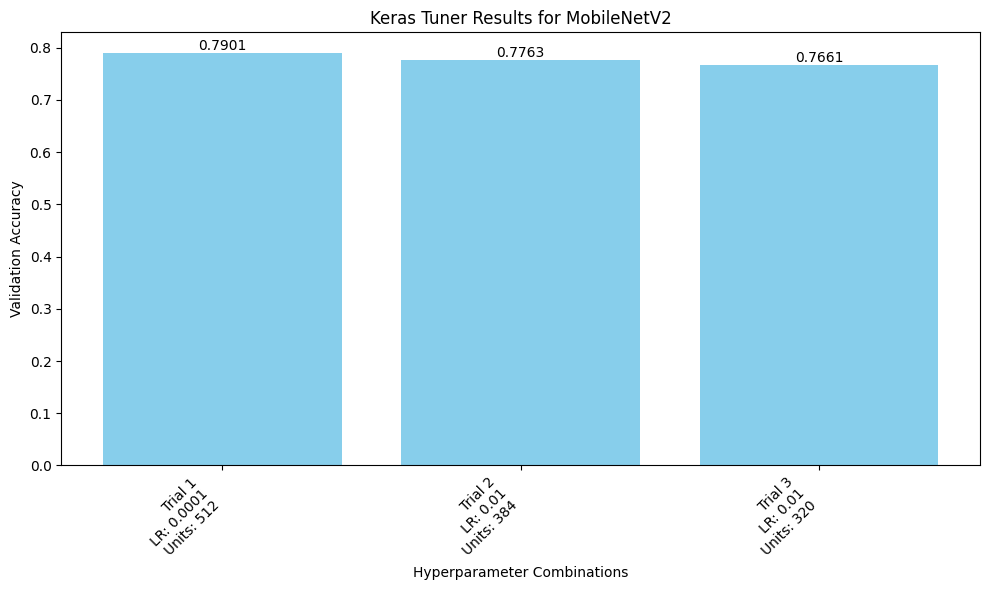

Total Parameters for MobileNetV2: 2918986

Best hyperparameters for MobileNetV2:
  - Learning Rate: 0.0001
  - Dense Units: 512

Starting final training of the best MobileNetV2 model...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.7028 - loss: 0.8529 - val_accuracy: 0.8033 - val_loss: 0.5724
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.7156 - loss: 0.8133 - val_accuracy: 0.8120 - val_loss: 0.5494
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.7260 - loss: 0.7799 - val_accuracy: 0.8139 - val_loss: 0.5534
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.7387 - loss: 0.7513 - val_accuracy: 0.8151 - val_loss: 0.5340
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.7446 - loss: 0.7255 - val_accuracy: 0.8169 - val_loss: 0.5351
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.7463 - loss: 0.7207 - val_accuracy: 0.8273 - val_loss: 0.5017
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.7501 - loss: 0.7004 - val_accuracy: 0.8270 - val_loss: 0.5067
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.7570 - loss: 0.6935 - val_accurac

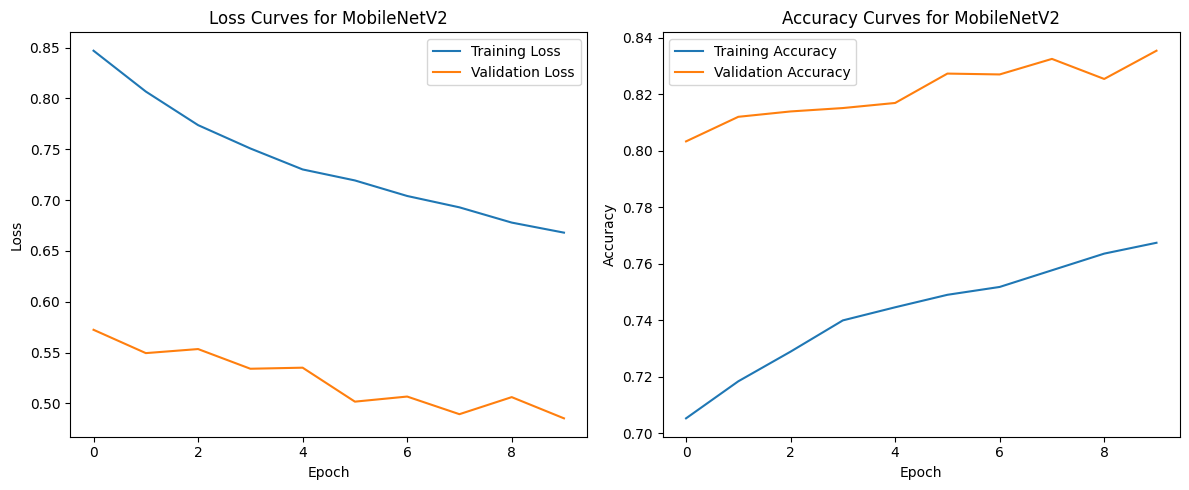

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8361 - loss: 0.4896

Final Test Loss (MobileNetV2 on CIFAR-10): 0.4852
Final Test Accuracy (MobileNetV2 on CIFAR-10): 0.8354

--- Evaluating MobileNetV2 on CINIC-10 Test Dataset ---
Loading CINIC-10 test dataset for evaluation...
Found 5000 files belonging to 10 classes.
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.6290 - loss: 1.2583

Final Test Loss (MobileNetV2 on CINIC-10): 1.4804
Final Test Accuracy (MobileNetV2 on CINIC-10): 0.5656
157/157 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step
Inference Time per Sample (MobileNetV2): 0.0620 seconds
Calculating model size in memory...
In-memory Model Size (MobileNetV2): 11.14 MB

Generating confusion matrix for MobileNetV2 on CIFAR-10...
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step

Classification Report for MobileNetV2 on CIFAR-10:
              precision    recall  f1-score   support

    airplane       0.91      0.82      0.86      1000
  automobile       0.85      0.94      0.90     

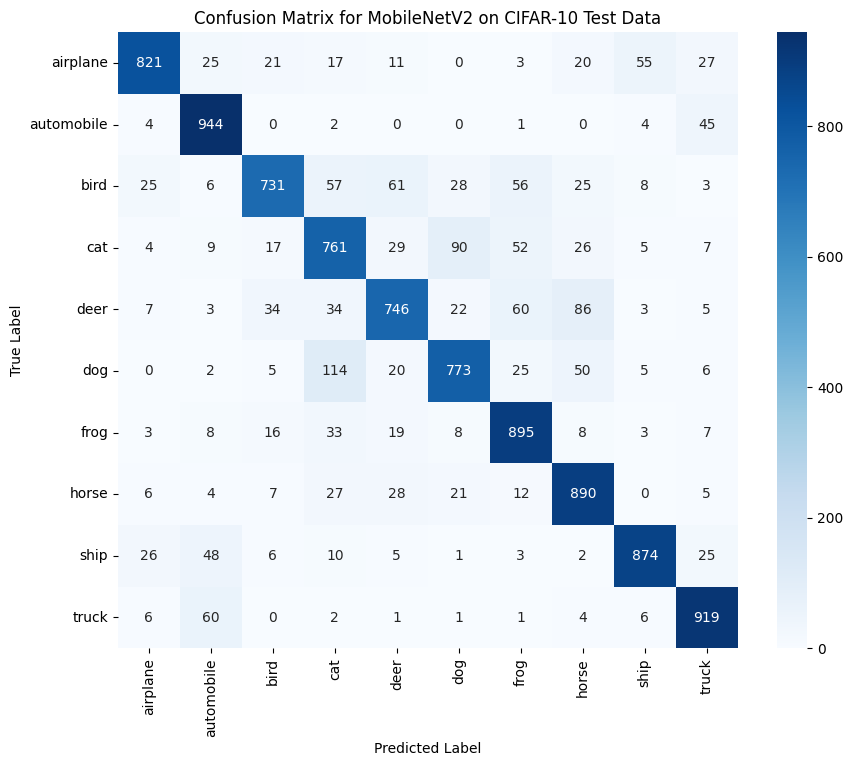

Model saved successfully to /content/drive/MyDrive/models/mobilenetv2_cifar10.keras.
File-based Model Size (MobileNetV2): 16.74 MB

====================== Pipeline for MobileNetV2 Finished ======================


In [ ]:
# Run the pipeline for MobileNetV2
mobilenet_results = run_model_pipeline(
model_name="MobileNetV2",
build_hypermodel_func=build_hypermodel_mobilenet,
preprocess_func=mobilenet_preprocess,
tuner_dir="tuner_results_mobilenet",
save_path="models/mobilenetv2_cifar10.keras",
folder_prefix = SAVE_FOLDER_PREFIX)
all_results["MobileNetV2"] = mobilenet_results


In [ ]:
mobilenet_results['model'].summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,240,992 (16.18 MB)

 Trainable params: 661,002 (2.52 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 1,322,006 (5.04 MB)

### Performance Analysis of the MobileNetV2 Model
#### HyperParameter Tuning

The plot shows the validation accuracy for each hyperparameter combination tested. The best trial with a learning rate of 0.0001 and 512 dense units was selected for the final model.

#### Analysis of Training Performance

The plots show a healthy and consistent training process. Both the training and validation metrics are moving in the right direction.

**Accuracy**: The training accuracy starts at 70.28% and steadily increases to 76.80%. At the same time, the validation accuracy, which is a more important indicator of the model's ability to generalize, also improves from 80.33% to 83.54%. The validation accuracy is consistently higher than the training accuracy in the early epochs. This is common with some models, especially those using techniques like data augmentation, and indicates that the model is learning features that generalize well to unseen data.

**Loss**: The loss metric measures the model's error. The training loss decreases from 0.8529 to 0.6662, showing the model is getting better at fitting the training data. Similarly, the validation loss drops from 0.5724 to 0.4852. The fact that both losses are consistently decreasing is a great sign. It confirms that the model is effectively learning and not just memorizing the training data.

#### Per-Class Performance

**Best-Performing Classes**: The model performs exceptionally well on automobile, ship, and truck images. These classes have very high precision, recall, and f1-scores (all above 0.85).

**Worst-Performing Classes**: The model has the most difficulty with the cat, bird, and deer classes. This is demonstrated by lower precision and recall for cat, and low recall for bird and deer.

Heatmap observations give us insight into True Positives and False Negatives on a per class basis.

<br/>**Training Time is 259.27 seconds**


#### Custom Data Testing with CINIC10

Eventhough the validation accuracy is 83.54%, the accuracy of custom CINIC10 data is only 56.56% which could point to overfitting and poor generalization.


#### Other Metrics

- Inference Time per Sample is 0.0620 seconds
- In-memory Model Size is 11.14 MB
- File-based Model Size is 16.74 MB


Trial 3 Complete [00h 02m 12s]
val_accuracy: 0.8716500103473663

Best val_accuracy So Far: 0.8716500103473663
Total elapsed time: 00h 06m 39s
Hyperparameter search time for ResNet50: 405.50 seconds

Plotting hyperparameter tuning results for ResNet50...


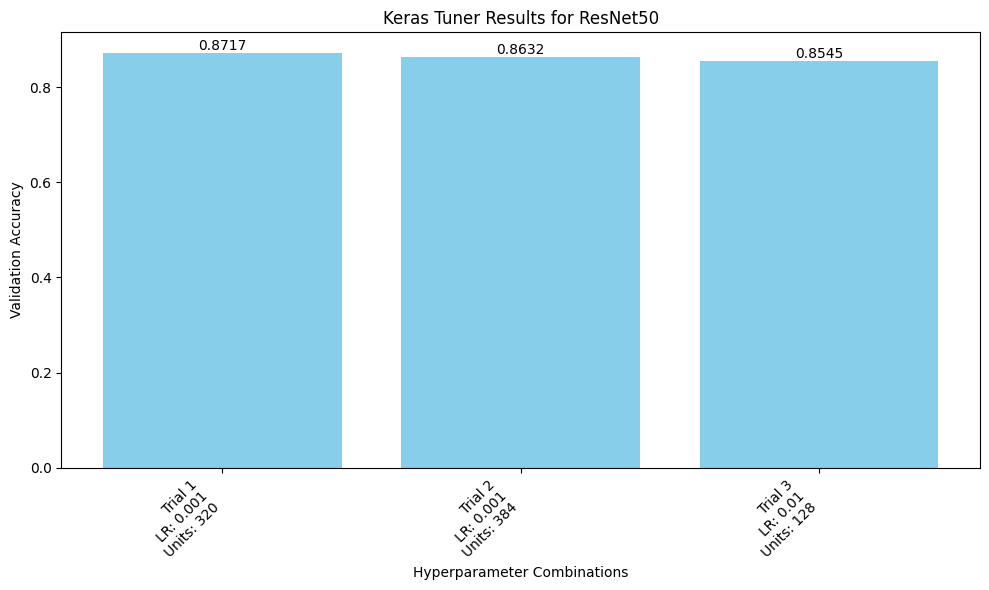

Total Parameters for ResNet50: 24246602

Best hyperparameters for ResNet50:
  - Learning Rate: 0.001
  - Dense Units: 320

Starting final training of the best ResNet50 model...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


782/782 ━━━━━━━━━━━━━━━━━━━━ 60s 63ms/step - accuracy: 0.8024 - loss: 0.5754 - val_accuracy: 0.8820 - val_loss: 0.3484
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.8176 - loss: 0.5192 - val_accuracy: 0.8968 - val_loss: 0.2991
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.8313 - loss: 0.4743 - val_accuracy: 0.8929 - val_loss: 0.3153
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.8407 - loss: 0.4421 - val_accuracy: 0.8962 - val_loss: 0.3113
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.8480 - loss: 0.4243 - val_accuracy: 0.8984 - val_loss: 0.2997
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.8564 - loss: 0.4100 - val_accuracy: 0.8848 - val_loss: 0.3484
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.8569 - loss: 0.3989 - val_accuracy: 0.8958 - val_loss: 0.3124
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 39s 49ms/step - accuracy: 0.8654 - loss: 0.3787 - val_accurac

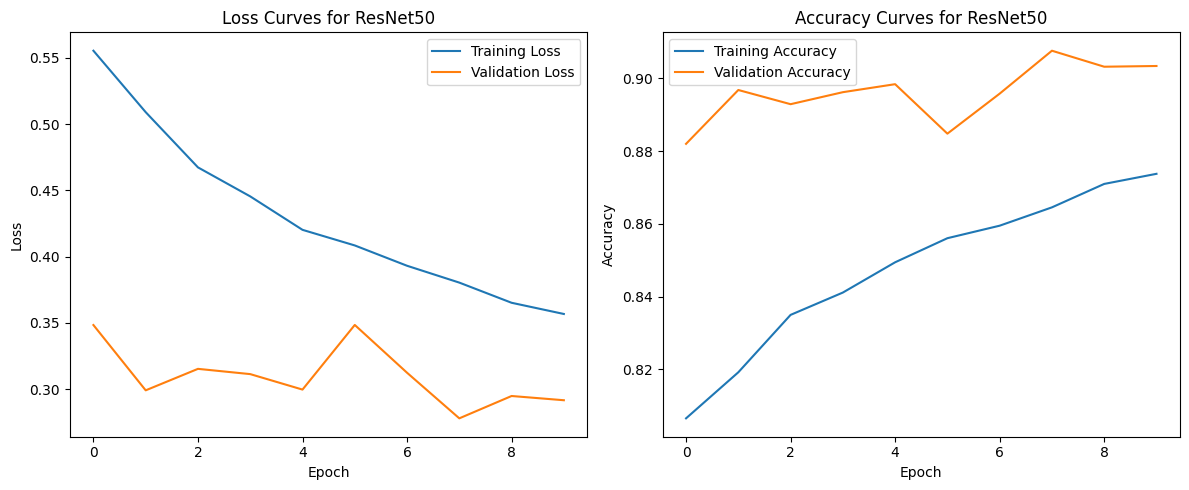

157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.9000 - loss: 0.3014

Final Test Loss (ResNet50 on CIFAR-10): 0.2916
Final Test Accuracy (ResNet50 on CIFAR-10): 0.9034

--- Evaluating ResNet50 on CINIC-10 Test Dataset ---
Loading CINIC-10 test dataset for evaluation...
Found 5000 files belonging to 10 classes.
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 98ms/step - accuracy: 0.6867 - loss: 1.3408

Final Test Loss (ResNet50 on CINIC-10): 1.7431
Final Test Accuracy (ResNet50 on CINIC-10): 0.6084
157/157 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step
Inference Time per Sample (ResNet50): 0.0836 seconds
Calculating model size in memory...
In-memory Model Size (ResNet50): 92.49 MB

Generating confusion matrix for ResNet50 on CIFAR-10...
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step

Classification Report for ResNet50 on CIFAR-10:
              precision    recall  f1-score   support

    airplane       0.94      0.89      0.91      1000
  automobile       0.91      0.96      0.94      1000
        bird       0.9

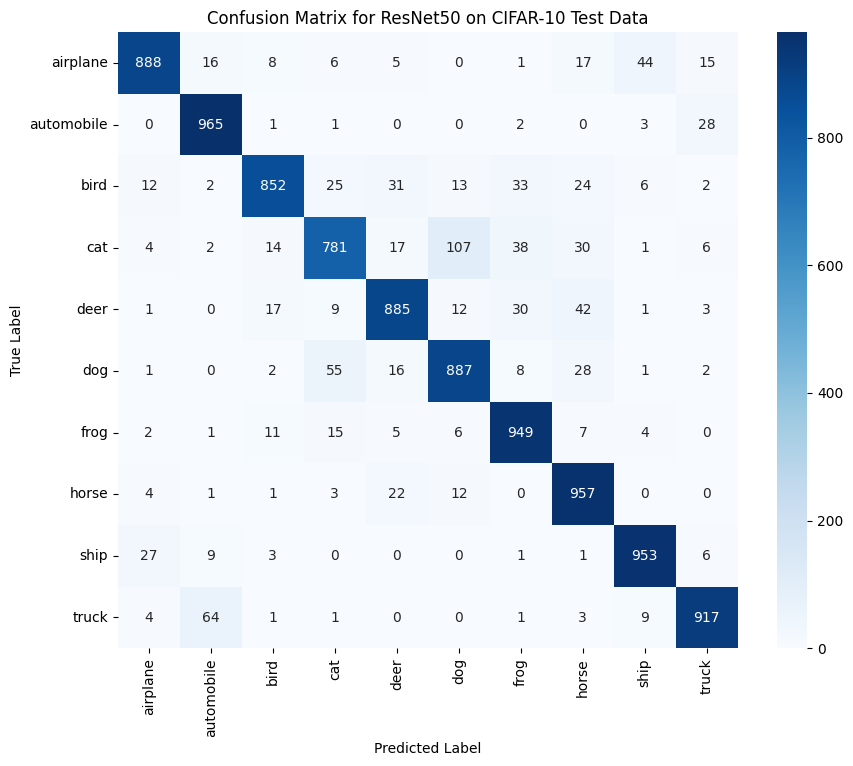

Model saved successfully to /content/drive/MyDrive/models/resnet50_cifar10.keras.
File-based Model Size (ResNet50): 98.15 MB

====================== Pipeline for ResNet50 Finished ======================


In [ ]:
 # Run the pipeline for ResNet50
resnet_results = run_model_pipeline(
    model_name="ResNet50",
    build_hypermodel_func=build_hypermodel_resnet,
    preprocess_func=resnet_preprocess,
    tuner_dir="tuner_results_resnet",
    save_path="models/resnet50_cifar10.keras",
    folder_prefix = SAVE_FOLDER_PREFIX)

all_results["ResNet50"] = resnet_results


In [ ]:
resnet_results['model'].summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │       655,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         3,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,564,384 (97.52 MB)

 Trainable params: 658,890 (2.51 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 1,317,782 (5.03 MB)

### Performance Analysis of the ResNet50 Model
#### HyperParameter Tuning

The plot shows the validation accuracy for each hyperparameter combination tested. The best trial with a learning rate of 0.001 and 320 dense units was selected for the final model.

#### Analysis of Training Performance

The plots show a healthy and consistent training process. Both the training and validation metrics are moving in the right direction.

**Accuracy**: The training accuracy starts at 80.24% and climbs steadily to 87.58% by the tenth epoch. The validation accuracy starts even higher at 88.20% and reaches 90.34%. The fact that your validation accuracy is higher than your training accuracy suggests the model is generalizing its learned patterns well to unseen data without memorizing the training set.

**Loss**: The training loss, which is the model's error on the training data, decreases from 57.54% to 35.04%. The validation loss, the error on unseen data, also drops from 34.84% to 29.16%. The consistent decrease in both loss values confirms that the model is effectively learning and improving.

#### Per-Class Performance

**Best-Performing Class**: The model performs exceptionally well on the automobile, ship, frog, truck and horse classes, all with f1-scores of 0.91 or higher. This suggests these objects have highly distinguishable features that the model has learned effectively. The high recall for automobile (0.96) and horse (0.96) is particularly impressive, meaning the model is very good at identifying nearly all instances of these classes.

**Worst-Performing Class**: While still performing well overall, the cat class remains the most challenging, with the lowest f1-score (0.82) and recall (0.78).

Heatmap observations give us insight into True Positives and False Negatives on a per class basis.

<br/>**Training Time is 408.84 seconds**


#### Custom Data Testing with CINIC10

Eventhough the validation accuracy is 90.34%, the accuracy of custom CINIC10 data is only 60.84% which could point to overfitting and poor generalization.


#### Other Metrics

- Inference Time per Sample is 0.0820 seconds
- In-memory Model Size is 92.49 MB
- File-based Model Size is 98.15 MB

Trial 3 Complete [00h 02m 25s]
val_accuracy: 0.8794000148773193

Best val_accuracy So Far: 0.8794000148773193
Total elapsed time: 00h 07m 14s
Hyperparameter search time for EfficientNetB0: 437.89 seconds

Plotting hyperparameter tuning results for EfficientNetB0...


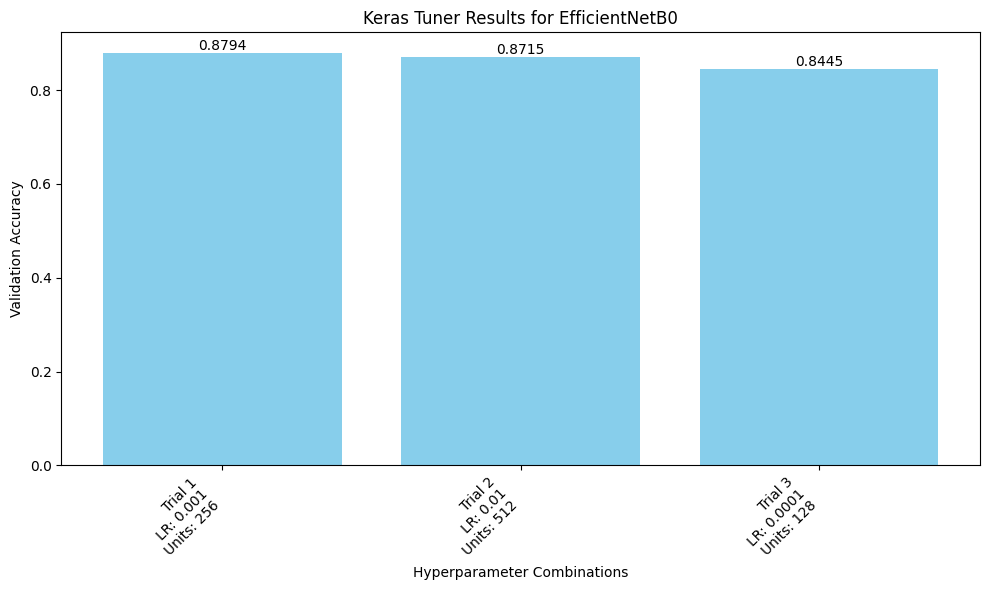

Total Parameters for EfficientNetB0: 4380077

Best hyperparameters for EfficientNetB0:
  - Learning Rate: 0.001
  - Dense Units: 256

Starting final training of the best EfficientNetB0 model...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


782/782 ━━━━━━━━━━━━━━━━━━━━ 64s 57ms/step - accuracy: 0.7737 - loss: 0.6462 - val_accuracy: 0.8902 - val_loss: 0.3148
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.7900 - loss: 0.5967 - val_accuracy: 0.8897 - val_loss: 0.3202
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8016 - loss: 0.5606 - val_accuracy: 0.8875 - val_loss: 0.3223
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8141 - loss: 0.5292 - val_accuracy: 0.9002 - val_loss: 0.2927
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8127 - loss: 0.5226 - val_accuracy: 0.8993 - val_loss: 0.3040
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 32ms/step - accuracy: 0.8242 - loss: 0.4995 - val_accuracy: 0.8964 - val_loss: 0.3056
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8302 - loss: 0.4844 - val_accuracy: 0.9035 - val_loss: 0.2870
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.8325 - loss: 0.4694 - val_accurac

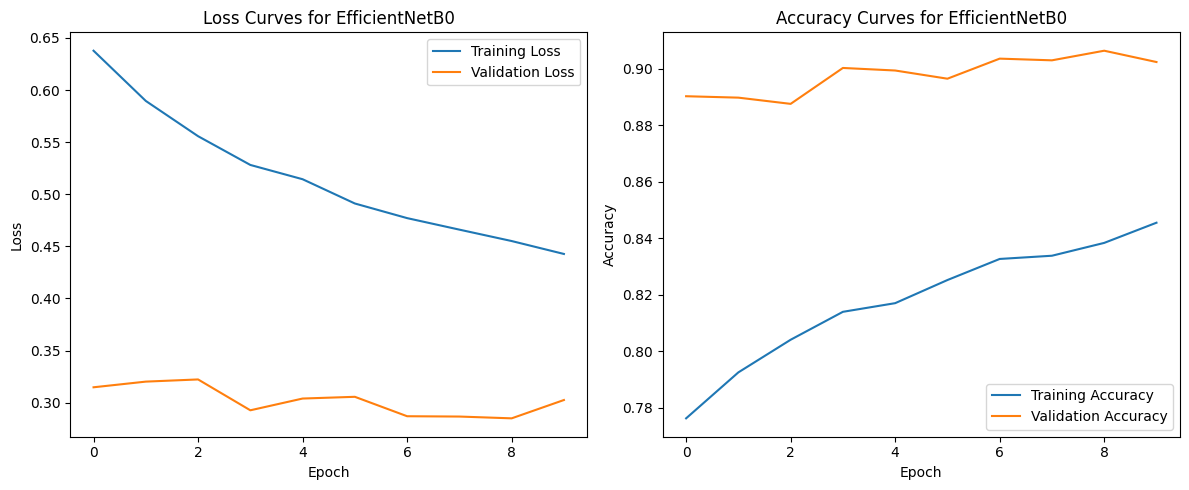

157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9037 - loss: 0.3091

Final Test Loss (EfficientNetB0 on CIFAR-10): 0.3026
Final Test Accuracy (EfficientNetB0 on CIFAR-10): 0.9023

--- Evaluating EfficientNetB0 on CINIC-10 Test Dataset ---
Loading CINIC-10 test dataset for evaluation...
Found 5000 files belonging to 10 classes.
79/79 ━━━━━━━━━━━━━━━━━━━━ 19s 160ms/step - accuracy: 0.6985 - loss: 1.2287

Final Test Loss (EfficientNetB0 on CINIC-10): 1.5707
Final Test Accuracy (EfficientNetB0 on CINIC-10): 0.6300
157/157 ━━━━━━━━━━━━━━━━━━━━ 15s 58ms/step
Inference Time per Sample (EfficientNetB0): 0.0983 seconds
Calculating model size in memory...
In-memory Model Size (EfficientNetB0): 16.71 MB

Generating confusion matrix for EfficientNetB0 on CIFAR-10...
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step

Classification Report for EfficientNetB0 on CIFAR-10:
              precision    recall  f1-score   support

    airplane       0.95      0.89      0.92      1000
  automobile       0.

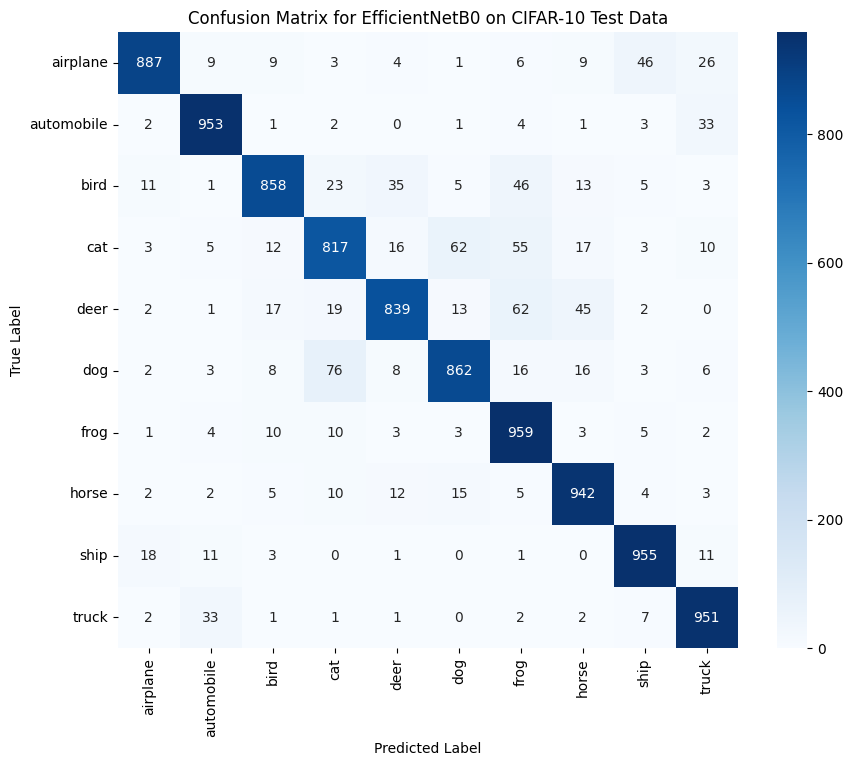

Model saved successfully to /content/drive/MyDrive/models/efficientnetb0_cifar10.keras.
File-based Model Size (EfficientNetB0): 20.04 MB

====================== Pipeline for EfficientNetB0 Finished ======================


In [ ]:
# Run the pipeline for EfficientNetB0
efficientnet_results = run_model_pipeline(
    model_name="EfficientNetB0",
    build_hypermodel_func=build_hypermodel_efficientnet,
    preprocess_func=efficientnet_preprocess,
    tuner_dir="tuner_results_efficientnet",
    save_path="models/efficientnetb0_cifar10.keras",
    folder_prefix = SAVE_FOLDER_PREFIX)

all_results["EfficientNetB0"] = efficientnet_results

In [ ]:
efficientnet_results['model'].summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,041,091 (19.23 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 661,014 (2.52 MB)

### Performance Analysis of the EfficientNetB0 Model
#### HyperParameter Tuning

The plot shows the validation accuracy for each hyperparameter combination tested. The best trial with a learning rate of 0.001 and 256 dense units was selected for the final model.

#### Analysis of Training Performance

The plots show a healthy and consistent training process. Both the training and validation metrics are moving in the right direction.

**Accuracy**: The training accuracy starts at 77.37% and climbs steadily to 84.41% The validation accuracy starts even higher at 89.02% and reaches 90.68% in Epoch 9. The slight dip to 90.23% in the final epoch is very minor, may be a   sign that the model is starting to overfit.

**Loss**: The training loss, which is the model's error on the training data, decreases from 64.62% to 44.73%. The validation loss starts at 31.48% and follows a generally downward path, reaching its lowest point in Epoch 9 at 28.50%. The loss slightly rises to 30.26% in the last epoch. This small increase, coupled with the slight drop in validation accuracy may be a warning sign of overfitting.


#### Per-Class Performance

**Best-Performing Class**: The model is particularly strong at identifying airplane, automobile, horse, ship, and truck. These classes all have precision, recall, and F1-scores above 0.90, indicating the model is very confident and accurate with them.  
** Low Performance Class**: Cat class has the lowest F1-score of (0.83). The recall (0.82) is also the lowest, meaning it misses portion of the actual cat images misclassifying them as other animals.

Bird class also has a lower F1-score (0.89) compared to others. While its precision is high (0.93), its recall is lower (0.86), indicating the model is good at identifying birds but still misses some of them, possibly confusing them with other small animals.

The Frog class has the lowest precision of 83%  but the highest recall of 96%. This means the model is very good at identifying nearly all the frogs, but it also has a higher tendency to incorrectly label other images as "frog."

Heatmap observations give us insight into True Positives and False Negatives on a per class basis.

<br/>**Training Time is 296.73 seconds**


#### Custom Data Testing with CINIC10

Eventhough the validation accuracy is 90.23%, the accuracy of custom CINIC10 data is only 63% which could point to overfitting and poor generalization.


#### Other Metrics

- Inference Time per Sample is 0.0983 seconds
- In-memory Model Size is 16.71 MB
- File-based Model Size is 20.04 MB

Trial 3 Complete [00h 03m 27s]
val_accuracy: 0.8445999920368195

Best val_accuracy So Far: 0.8623499870300293
Total elapsed time: 00h 10m 36s
Hyperparameter search time for DenseNet121: 641.41 seconds

Plotting hyperparameter tuning results for DenseNet121...


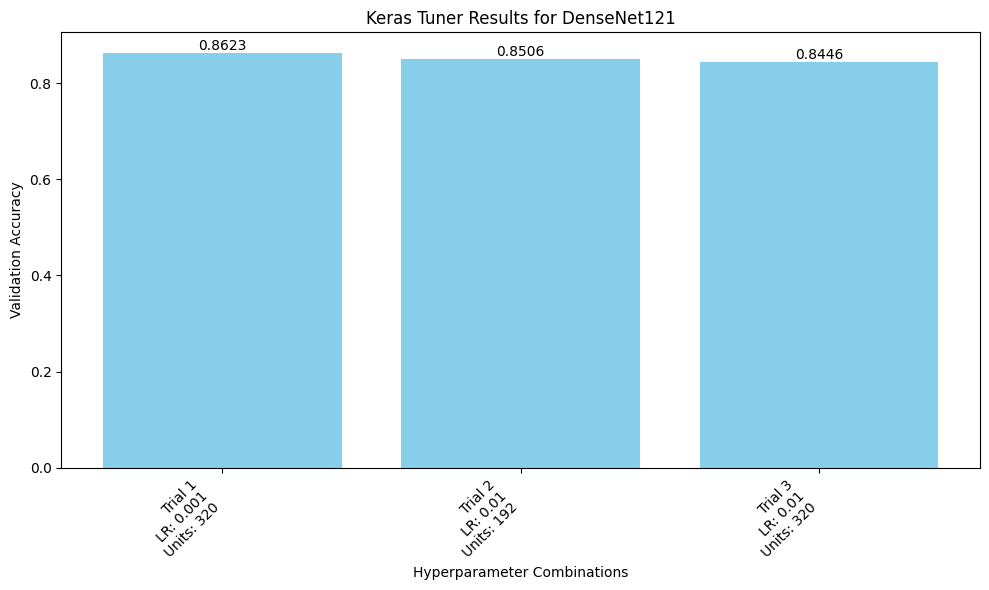

Total Parameters for DenseNet121: 7368714

Best hyperparameters for DenseNet121:
  - Learning Rate: 0.001
  - Dense Units: 320

Starting final training of the best DenseNet121 model...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


782/782 ━━━━━━━━━━━━━━━━━━━━ 96s 92ms/step - accuracy: 0.7464 - loss: 0.7161 - val_accuracy: 0.8716 - val_loss: 0.3737
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.7650 - loss: 0.6751 - val_accuracy: 0.8766 - val_loss: 0.3611
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.7780 - loss: 0.6361 - val_accuracy: 0.8727 - val_loss: 0.3751
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.7905 - loss: 0.6034 - val_accuracy: 0.8789 - val_loss: 0.3648
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.7960 - loss: 0.5842 - val_accuracy: 0.8856 - val_loss: 0.3374
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.7978 - loss: 0.5783 - val_accuracy: 0.8799 - val_loss: 0.3484
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 51ms/step - accuracy: 0.7985 - loss: 0.5714 - val_accuracy: 0.8858 - val_loss: 0.3331
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 51ms/step - accuracy: 0.8070 - loss: 0.5468 - val_accurac

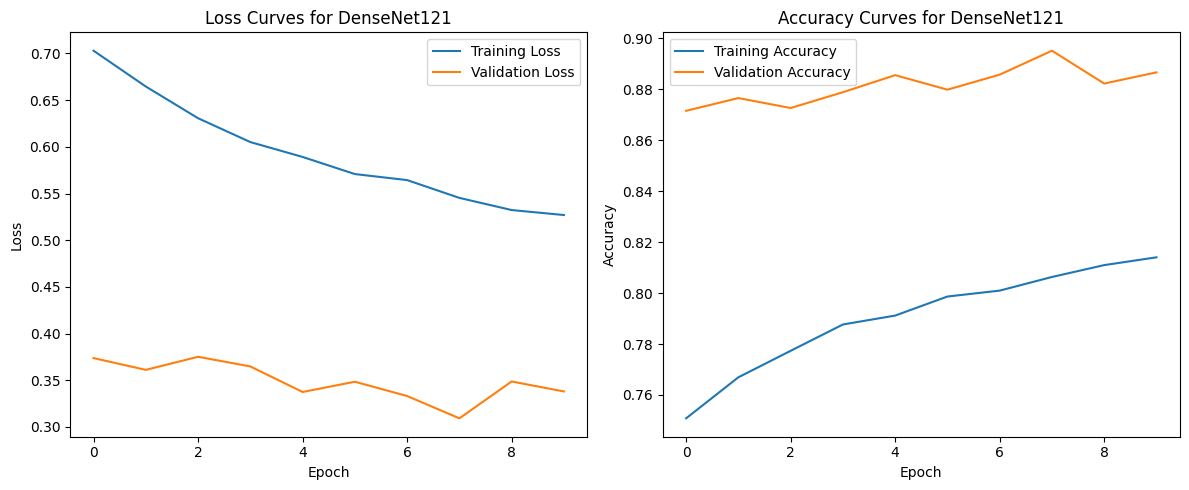

157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.8831 - loss: 0.3445

Final Test Loss (DenseNet121 on CIFAR-10): 0.3380
Final Test Accuracy (DenseNet121 on CIFAR-10): 0.8867

--- Evaluating DenseNet121 on CINIC-10 Test Dataset ---
Loading CINIC-10 test dataset for evaluation...
Found 5000 files belonging to 10 classes.
79/79 ━━━━━━━━━━━━━━━━━━━━ 29s 199ms/step - accuracy: 0.6591 - loss: 1.2758

Final Test Loss (DenseNet121 on CINIC-10): 1.5251
Final Test Accuracy (DenseNet121 on CINIC-10): 0.6068
157/157 ━━━━━━━━━━━━━━━━━━━━ 30s 111ms/step
Inference Time per Sample (DenseNet121): 0.1914 seconds
Calculating model size in memory...
In-memory Model Size (DenseNet121): 28.11 MB

Generating confusion matrix for DenseNet121 on CIFAR-10...
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step

Classification Report for DenseNet121 on CIFAR-10:
              precision    recall  f1-score   support

    airplane       0.92      0.86      0.89      1000
  automobile       0.94      0.92      0.93    

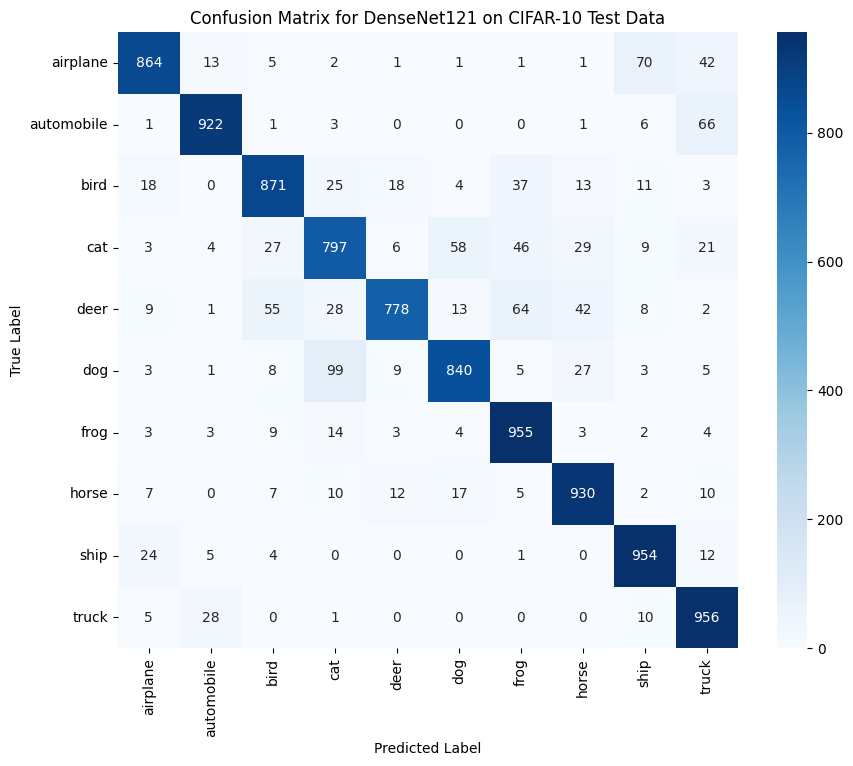

Model saved successfully to /content/drive/MyDrive/models/densenet121_cifar10.keras.
File-based Model Size (DenseNet121): 32.09 MB

====================== Pipeline for DenseNet121 Finished ======================


In [ ]:
# Run the pipeline for DenseNet121
densenet_results = run_model_pipeline(
    model_name="DenseNet121",
    build_hypermodel_func=build_hypermodel_densenet,
    preprocess_func=densenet_preprocess,
    tuner_dir="tuner_results_densenet",
    save_path="models/densenet121_cifar10.keras",
    folder_prefix = SAVE_FOLDER_PREFIX)

all_results["DenseNet121"] = densenet_results

In [ ]:
densenet_results['model'].summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 320)            │       328,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         3,210 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,031,136 (30.64 MB)

 Trainable params: 331,210 (1.26 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 662,422 (2.53 MB)

### Performance Analysis of the DenseNet121 Model
#### HyperParameter Tuning

The plot shows the validation accuracy for each hyperparameter combination tested. The best trial with a learning rate of 0.001 and 320 dense units was selected for the final model.

#### Analysis of Training Performance


**Accuracy**: The training accuracy starts at 74.64% and climbs steadily to 81.37% The validation accuracy starts even higher at 87.16% and reaches 89.52% in Epoch 8. In the last two epochs, a slight drop in accuracy  may be an indicator of overfitting.

**Loss**: The training loss, which is the model's error on the training data, decreases from 71.51% to 52.98%. The validation loss starts at 37.37% and follows a generally downward path, reaching its lowest point in Epoch 8 at 30.92% The loss slightly rises to 33.80% in the last epoch. Even though the validation loss goes up slightly after epoch 8, training loss continue to decrease signaling overfitting.


#### Per-Class Performance

**Best-Performing Class**: The model excelled at identifying automobile (F1-score: 0.93), horse (F1-score: 0.91), and ship (F1-score: 0.92). These high scores suggest the model is both precise and good at finding these objects.

**Low Performing Class**: The model struggled most with the cat and deer classes. The cat class had the lowest F1-score (0.81) which has been the common theme across models. The deer class has a very high precision (0.94) but a much lower recall (0.78), suggesting that while the model is very confident when it predicts deer, it also missed many of the actual deer images in the test set, likely confusing them with horses or other animals.

The truck class is an interesting example of a trade-off. It has a high recall (0.96), meaning it found almost all the trucks, but a lower precision (0.85), which indicates it sometimes incorrectly labeled other objects as trucks. The opposite is true for deer which had high precision and low recall

Heatmap observations give us insight into True Positives and False Negatives on a per class basis.

<br/>**Training Time is 460.39 seconds**


#### Custom Data Testing with CINIC10

Eventhough the validation accuracy is 88.67%, the accuracy of custom CINIC10 data is only 60.68% which could point to overfitting and poor generalization.


#### Other Metrics


- Inference Time per Sample is 0.1914 seconds
- In-memory Model Size is 28.11 MB
- File-based Model Size is 32.09 MB

### Printing Key Metrics from Model Training and Testing

In [ ]:
 # Print a summary of all results
print("\n\n====================== Overall Comparison of Results ======================")
for model_name, results in all_results.items():
  print(f"\n--- {model_name} ---")
  for key, value in results['metrics'].items():
    if isinstance(value, float):
      print(f"{key}: {value:.4f}")
    elif isinstance(value, dict):
      # Skip printing the full report for brevity in this summary
      print(f"{key}: available (see full results)")
    else:
      print(f"{key}: {value}")





====================== Overall Comparison of Results ======================

--- BaseModel ---
tuner_search_time: 156.0784
total_parameters: 5608586
training_time: 203.2964
cifar10_train_accuracy: 0.4698
cifar10_train_loss: 1.5115
cifar10_val_accuracy: 0.4888
cifar10_val_loss: 1.4487
cifar10_test_loss: 1.4487
cifar10_test_accuracy: 0.4888
cinic10_test_loss: 1.8305
cinic10_test_accuracy: 0.3536
inference_time_per_sample: 0.0112
in_memory_model_size_mb: 21.3951
classification_report: available (see full results)
file_based_model_size_mb: 64.2141

--- MobileNetV2 ---
tuner_search_time: 305.4169
total_parameters: 2918986
training_time: 259.2670
cifar10_train_accuracy: 0.7674
cifar10_train_loss: 0.6679
cifar10_val_accuracy: 0.8354
cifar10_val_loss: 0.4852
cifar10_test_loss: 0.4852
cifar10_test_accuracy: 0.8354
cinic10_test_loss: 1.4804
cinic10_test_accuracy: 0.5656
inference_time_per_sample: 0.0620
in_memory_model_size_mb: 11.1350
classification_report: available (see full results)
file_b

### Model Performance Comparison



====================== Plotting All Model Metrics for Comparison ======================


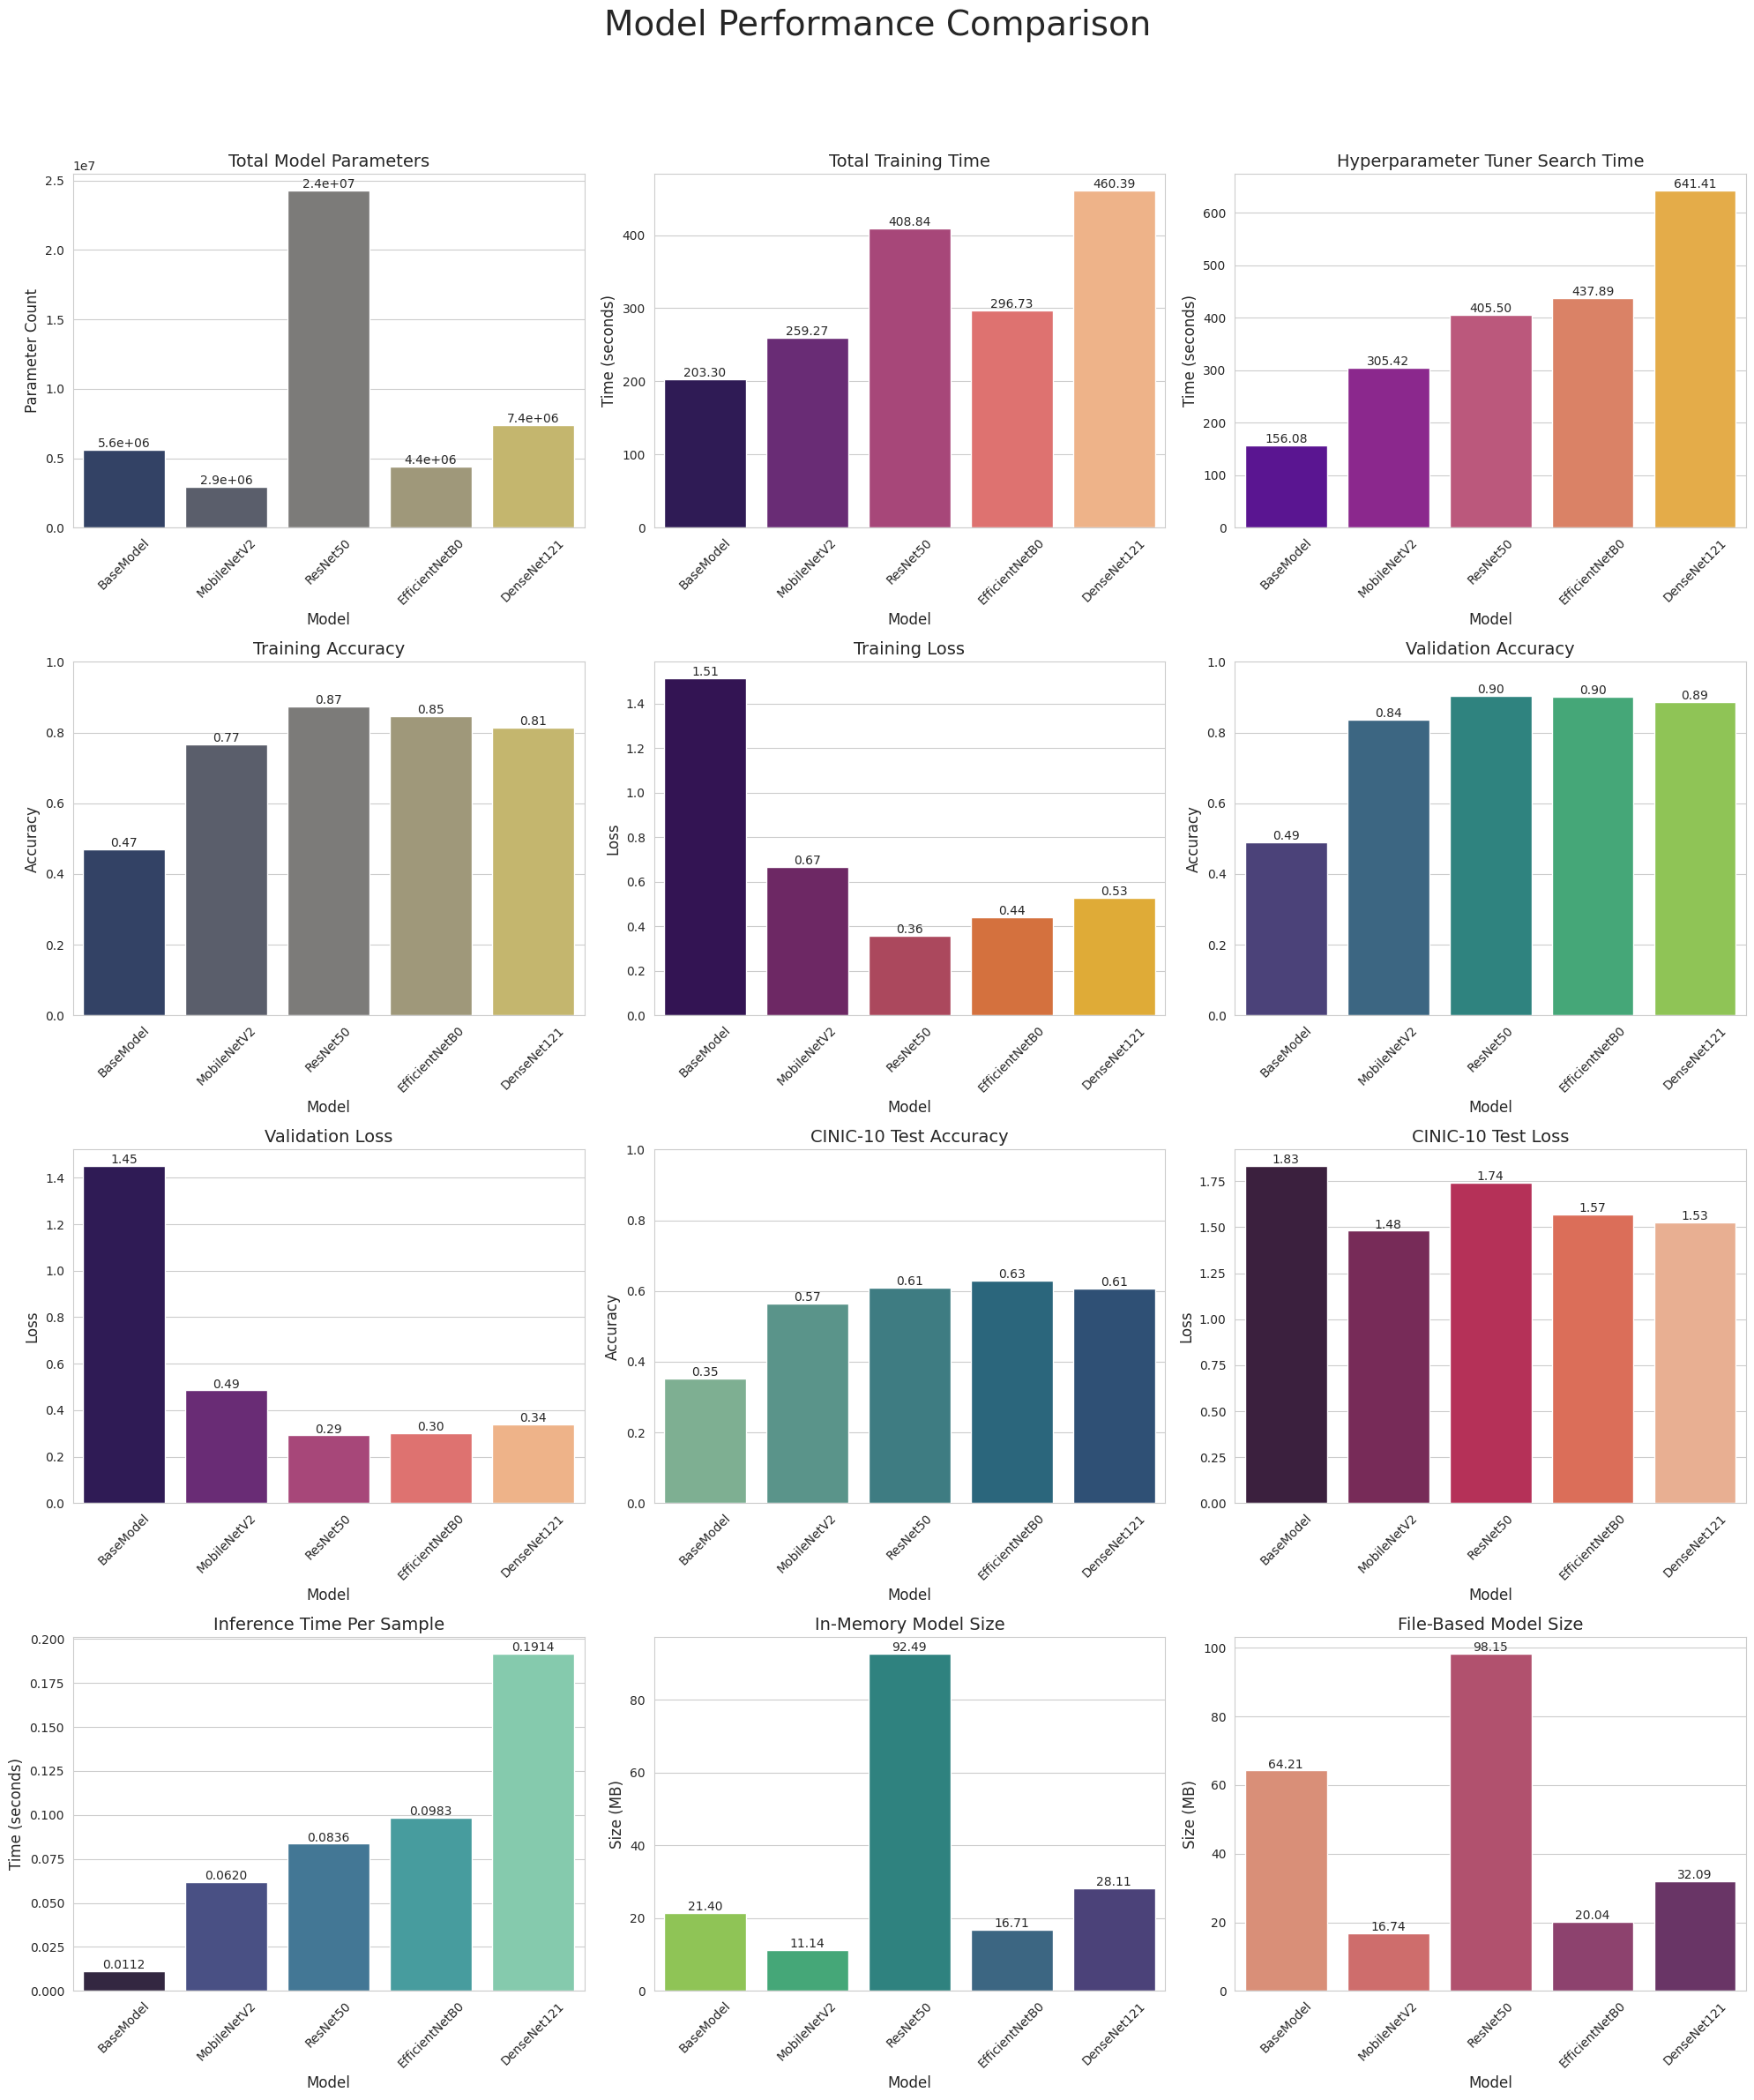

In [ ]:
# plot all model metrics
capstone_utils.plot_all_model_metrics(all_results)

### Overall Analysis

- The accuracy of the base model is low and therefore is not analyzed for other metrics.
- The validation accuracy of ResNet50, EfficientNetB0, and DenseNet121 models is comparable.
- ResNet50 has the highest training accuracy.
- The CINIC10 accuracy of ResNet50, EfficientNetB0, and DenseNet121 models is comparable.
- The ResNet50 model has the lowest training loss.
- The MobileNetV2 model has the lowest inference time per sample. This is not surprising as it was developed for mobile devices with resource constraints.
- The ResNet50 model consumes about three times more memory than the next highest memory-consuming model. This is due to the depth of the ResNet50 architecture.  

### Model Selction
- Based on accuracy and loss, ResNet50  and EfficientNetB0 models are comparable.
- Inference time per image is slightly better for ResNet50, whereas the EfficientNetB0 model is better at memory and disk consumption.
- CINIC10 performance on EfficientNetB0 was slightly better than ResNet50, particularly in terms of validation loss.
-  The EfficientNetB0 model will also work better on mobile devices due to its low memory footprint.
- **EfficientNetB0** is the final choice as it can also be used on mobile devices.


### Future Work

- Run more trials for Keras search.
- Train the best-fit model for more epochs (30+). Ten epochs were chosen due to compute considerations. Early Stopping could be used to make efficient use of comoute resources.
- Train with a larger subset of data from the CINIC10 dataset and use CIFAR10 for performance validation. This is a function of compute and memory availability.
